In [4]:
!pip install pandas numpy statsmodels scikit-learn tensorflow matplotlib

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt
from datetime import datetime

# Load the dataset
file_path = 'seaice.csv'
df = pd.read_csv(file_path)

# Clean column names
df.columns = df.columns.str.strip()

# Group by Year, Month, and Hemisphere to calculate average monthly Extent
monthly_avg = df.groupby(['Year', 'Month', 'hemisphere'])['Extent'].mean().reset_index()

# Display the first few rows
monthly_avg.head()

,Year,Month,hemisphere,Extent
0,1978,10,north,10.402667
1,1978,10,south,17.699000
2,1978,11,north,11.645133
3,1978,11,south,15.896400
4,1978,12,north,13.667063


In [5]:
# Common Functions

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {'R2': r2, 'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Recursive forecasting for LSTM/Bi-LSTM
def recursive_forecast(model, initial_sequence, steps, scaler):
    predictions = []
    current_sequence = initial_sequence.copy()
    for _ in range(steps):
        pred = model.predict(current_sequence.reshape(1, -1, 1), verbose=0)
        predictions.append(pred[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = pred[0, 0]
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Process each hemisphere
hemispheres = ['north', 'south']
metrics_dict = {'north': {}, 'south': {}}
short_term_forecasts = {'north': None, 'south': None}
long_term_forecasts = {'north': None, 'south': None}

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:582: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When usi

{'north': {'SARIMA': {'R2': 0.9953332780105881, 'MAE': 0.19321781510421365, 'MSE': 0.05121647006787063, 'RMSE': np.float64(0.2263105611054655)}, 'LSTM': {'R2': 0.9874549200606498, 'MAE': 0.30289776683456804, 'MSE': 0.13768009165117445, 'RMSE': np.float64(0.37105268042580486)}, 'Bi-LSTM': {'R2': 0.9807985863531193, 'MAE': 0.38736089514216215, 'MSE': 0.21073220764758113, 'RMSE': np.float64(0.459055778362043)}, 'SARIMA+LSTM': {'R2': 0.9945454916688988, 'MAE': 0.20920132910044117, 'MSE': 0.05986228948470123, 'RMSE': np.float64(0.24466771238702753)}, 'SARIMA+Bi-LSTM': {'R2': 0.9938208088383021, 'MAE': 0.205928526324493, 'MSE': 0.06781555873583012, 'RMSE': np.float64(0.26041420609450266)}}, 'south': {}}


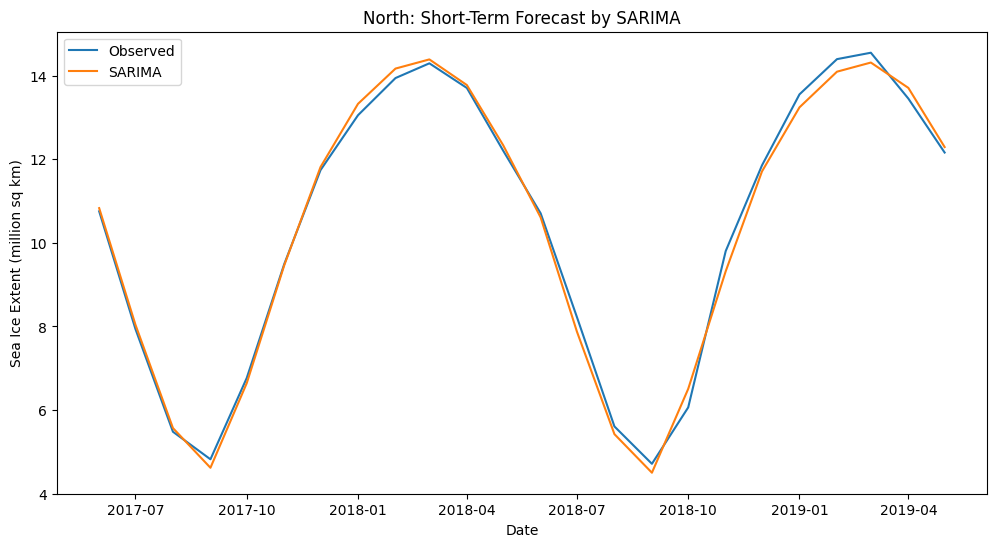

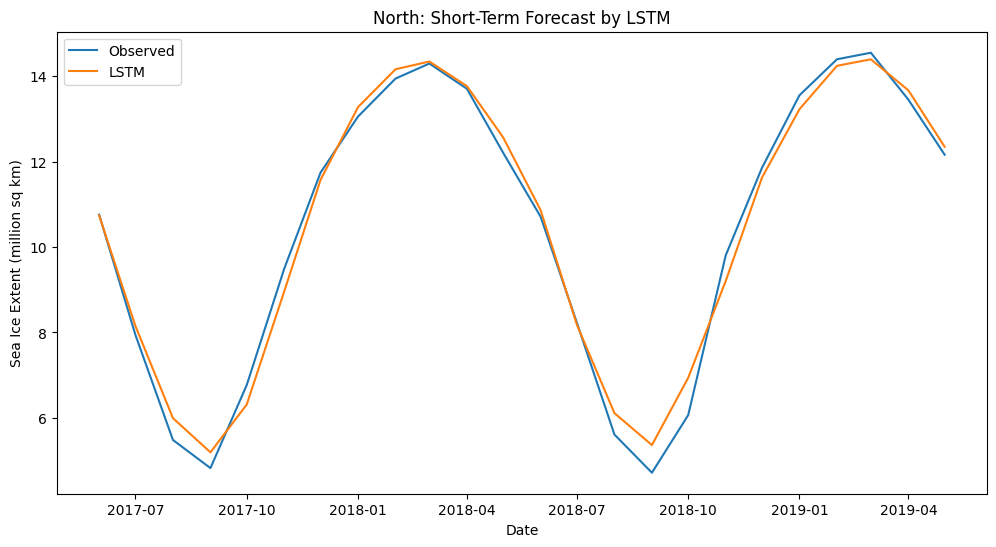

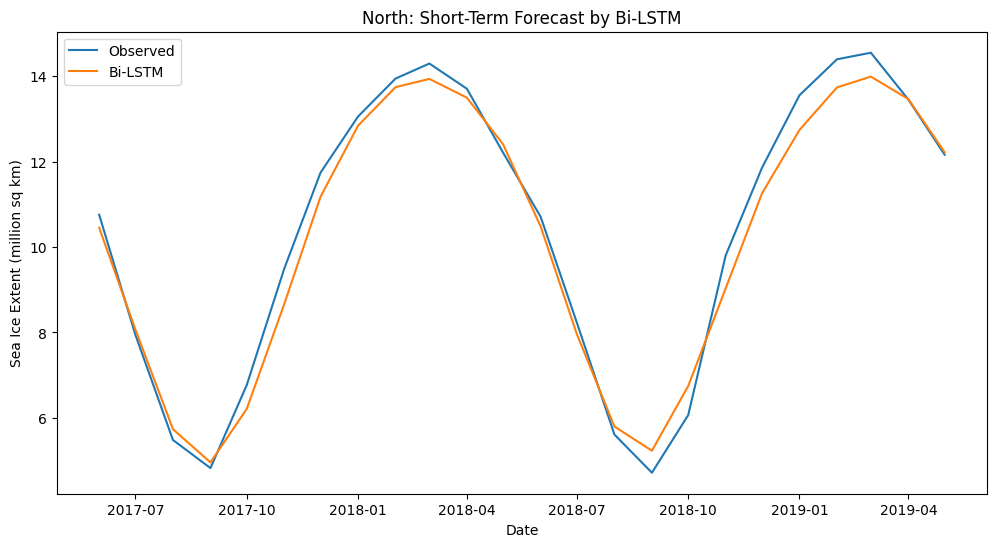

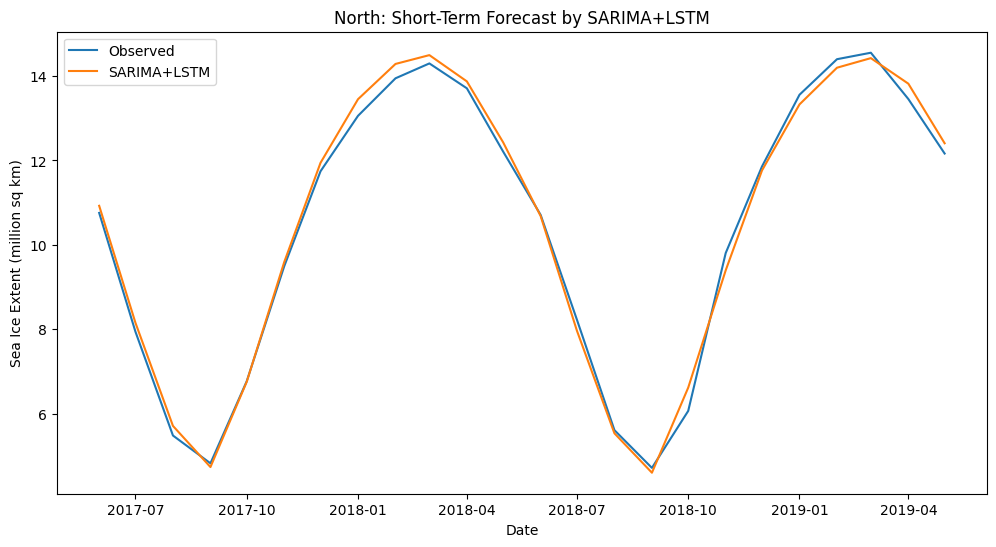

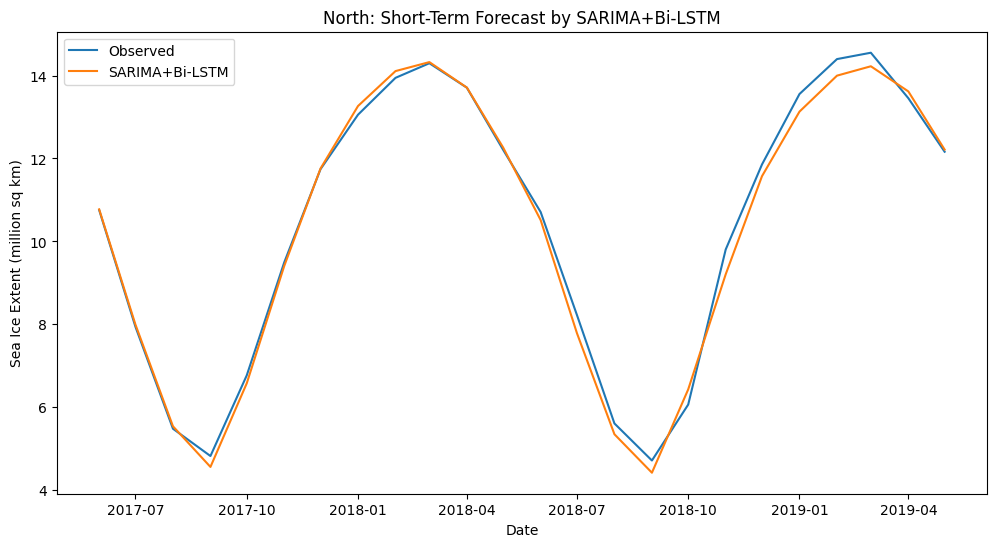

<Figure size 1200x600 with 0 Axes>

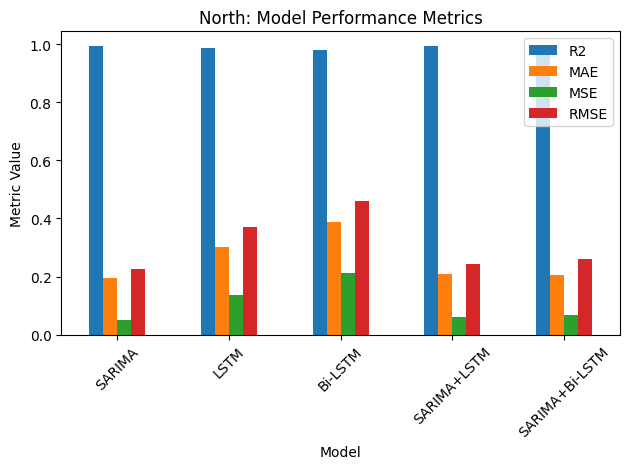

In [6]:
# Northern Hemisphere

# Filter and preprocess data
north_data = monthly_avg[monthly_avg['hemisphere'] == 'north'].copy()
north_data['Date'] = pd.to_datetime(north_data[['Year', 'Month']].assign(Day=1))
north_data = north_data.set_index('Date')[['Extent']]

# Split data
train_north = north_data.iloc[:-24]
test_north = north_data.iloc[-24:]

# SARIMA Model
sarima_model_north = SARIMAX(train_north['Extent'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit_north = sarima_model_north.fit(disp=False)
sarima_forecast_north = sarima_fit_north.forecast(steps=len(test_north))
metrics_dict['north']['SARIMA'] = calculate_metrics(test_north['Extent'], sarima_forecast_north)

# Long-term SARIMA forecast (to 2100)
future_dates_north = pd.date_range(start=north_data.index[-1] + pd.offsets.MonthBegin(1), end='2100-12-01', freq='MS')
sarima_long_forecast_north = sarima_fit_north.forecast(steps=len(future_dates_north))

# Prepare data for LSTM
scaler_north = MinMaxScaler()
scaled_data_north = scaler_north.fit_transform(north_data['Extent'].values.reshape(-1, 1))
# Clip scaled data to avoid extreme values
scaled_data_north = np.clip(scaled_data_north, -1e10, 1e10)
seq_length = 12
X_north, y_north = create_sequences(scaled_data_north, seq_length)
train_size_north = len(X_north) - 24
X_train_north, X_test_north = X_north[:train_size_north], X_north[train_size_north:]
y_train_north, y_test_north = y_north[:train_size_north], y_north[train_size_north:]

# LSTM Model
lstm_model_north = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=False),
    Dense(1)
])
lstm_model_north.compile(optimizer='adam', loss='mse')
lstm_model_north.fit(X_train_north, y_train_north, epochs=50, batch_size=32, verbose=0)
lstm_pred_north = lstm_model_north.predict(X_test_north, verbose=0)
lstm_pred_north = scaler_north.inverse_transform(lstm_pred_north)
y_test_true_north = scaler_north.inverse_transform(y_test_north)
metrics_dict['north']['LSTM'] = calculate_metrics(y_test_true_north.flatten(), lstm_pred_north.flatten())

# Long-term LSTM forecast with clipping
initial_sequence_north = np.clip(scaled_data_north[-seq_length:], -1e10, 1e10)
lstm_long_forecast_north = recursive_forecast(lstm_model_north, initial_sequence_north, len(future_dates_north), scaler_north)

# Bi-LSTM Model
bilstm_model_north = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(seq_length, 1)),
    Dense(1)
])
bilstm_model_north.compile(optimizer='adam', loss='mse')
bilstm_model_north.fit(X_train_north, y_train_north, epochs=50, batch_size=32, verbose=0)
bilstm_pred_north = bilstm_model_north.predict(X_test_north, verbose=0)
bilstm_pred_north = scaler_north.inverse_transform(bilstm_pred_north)
metrics_dict['north']['Bi-LSTM'] = calculate_metrics(y_test_true_north.flatten(), bilstm_pred_north.flatten())

# Long-term Bi-LSTM forecast with clipping
bilstm_long_forecast_north = recursive_forecast(bilstm_model_north, initial_sequence_north, len(future_dates_north), scaler_north)

# SARIMA+LSTM Model
# Compute residuals
sarima_train_pred_north = sarima_fit_north.predict(start=train_north.index[0], end=train_north.index[-1])
residuals_north = train_north['Extent'] - sarima_train_pred_north
scaler_residuals_north = MinMaxScaler()
scaled_residuals_north = scaler_residuals_north.fit_transform(residuals_north.values.reshape(-1, 1))
# Clip scaled residuals
scaled_residuals_north = np.clip(scaled_residuals_north, -1e10, 1e10)
X_res_north, y_res_north = create_sequences(scaled_residuals_north, seq_length)
train_size_res_north = len(X_res_north) - 24
X_train_res_north, X_test_res_north = X_res_north[:train_size_res_north], X_res_north[train_size_res_north:]
y_train_res_north, y_test_res_north = y_res_north[:train_size_res_north], y_res_north[train_size_res_north:]

# Train LSTM on residuals
lstm_residual_model_north = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=False),
    Dense(1)
])
lstm_residual_model_north.compile(optimizer='adam', loss='mse')
lstm_residual_model_north.fit(X_train_res_north, y_train_res_north, epochs=50, batch_size=32, verbose=0)
lstm_residual_pred_north = lstm_residual_model_north.predict(X_test_res_north, verbose=0)
lstm_residual_pred_north = scaler_residuals_north.inverse_transform(lstm_residual_pred_north)
sarima_lstm_pred_north = sarima_forecast_north + lstm_residual_pred_north.flatten()
metrics_dict['north']['SARIMA+LSTM'] = calculate_metrics(test_north['Extent'], sarima_lstm_pred_north)

# Long-term SARIMA+LSTM forecast
initial_residual_sequence_north = np.clip(scaled_residuals_north[-seq_length:], -1e10, 1e10)
lstm_residual_long_north = recursive_forecast(lstm_residual_model_north, initial_residual_sequence_north, len(future_dates_north), scaler_residuals_north)
sarima_lstm_long_north = sarima_long_forecast_north + lstm_residual_long_north.flatten()

# SARIMA+Bi-LSTM Model
bilstm_residual_model_north = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(seq_length, 1)),
    Dense(1)
])
bilstm_residual_model_north.compile(optimizer='adam', loss='mse')
bilstm_residual_model_north.fit(X_train_res_north, y_train_res_north, epochs=50, batch_size=32, verbose=0)
bilstm_residual_pred_north = bilstm_residual_model_north.predict(X_test_res_north, verbose=0)
bilstm_residual_pred_north = scaler_residuals_north.inverse_transform(bilstm_residual_pred_north)
sarima_bilstm_pred_north = sarima_forecast_north + bilstm_residual_pred_north.flatten()
metrics_dict['north']['SARIMA+Bi-LSTM'] = calculate_metrics(test_north['Extent'], sarima_bilstm_pred_north)

# Long-term SARIMA+Bi-LSTM forecast
bilstm_residual_long_north = recursive_forecast(bilstm_residual_model_north, initial_residual_sequence_north, len(future_dates_north), scaler_residuals_north)
sarima_bilstm_long_north = sarima_long_forecast_north + bilstm_residual_long_north.flatten()

# Save short-term forecasts
short_term_df_north = pd.DataFrame({
    'Date': test_north.index,
    'Actual': test_north['Extent'],
    'SARIMA': sarima_forecast_north,
    'LSTM': lstm_pred_north.flatten(),
    'Bi-LSTM': bilstm_pred_north.flatten(),
    'SARIMA+LSTM': sarima_lstm_pred_north,
    'SARIMA+Bi-LSTM': sarima_bilstm_pred_north
})
short_term_df_north.to_csv('short_term_forecasts_north.csv', index=False)

# Save long-term forecasts
long_term_df_north = pd.DataFrame({
    'Date': future_dates_north,
    'SARIMA': sarima_long_forecast_north,
    'LSTM': lstm_long_forecast_north.flatten(),
    'Bi-LSTM': bilstm_long_forecast_north.flatten(),
    'SARIMA+LSTM': sarima_lstm_long_north,
    'SARIMA+Bi-LSTM': sarima_bilstm_long_north
})
long_term_df_north.to_csv('long_term_forecasts_north.csv', index=False)


print(metrics_dict)
# Save metrics
metrics_df_north = pd.DataFrame(metrics_dict['north']).T
metrics_df_north.to_csv('metrics_north.csv')

# Visualizations
plt.figure(figsize=(12, 6))
plt.plot(test_north.index, test_north['Extent'], label='Observed')
plt.plot(test_north.index, sarima_forecast_north, label='SARIMA')
plt.title('North: Short-Term Forecast by SARIMA')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent (million sq km)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_north.index, test_north['Extent'], label='Observed')
plt.plot(test_north.index, lstm_pred_north, label='LSTM')
plt.title('North: Short-Term Forecast by LSTM')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent (million sq km)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_north.index, test_north['Extent'], label='Observed')
plt.plot(test_north.index, bilstm_pred_north, label='Bi-LSTM')
plt.title('North: Short-Term Forecast by Bi-LSTM')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent (million sq km)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_north.index, test_north['Extent'], label='Observed')
plt.plot(test_north.index, sarima_lstm_pred_north, label='SARIMA+LSTM')
plt.title('North: Short-Term Forecast by SARIMA+LSTM')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent (million sq km)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_north.index, test_north['Extent'], label='Observed')
plt.plot(test_north.index, sarima_bilstm_pred_north, label='SARIMA+Bi-LSTM')
plt.title('North: Short-Term Forecast by SARIMA+Bi-LSTM')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent (million sq km)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
metrics_df_north.plot(kind='bar')
plt.title('North: Model Performance Metrics')
plt.ylabel('Metric Value')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('metrics_north.png')
plt.show()

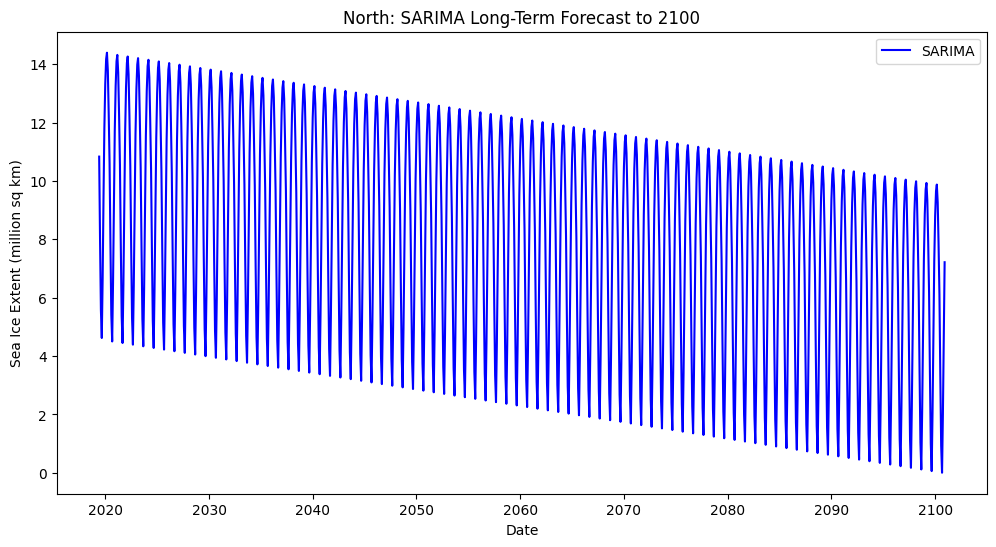

In [7]:
# Plot for SARIMA model
plt.figure(figsize=(12, 6))
plt.plot(future_dates_north, sarima_long_forecast_north, label='SARIMA', color='blue')
plt.title('North: SARIMA Long-Term Forecast to 2100')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent (million sq km)')
plt.legend()
plt.show()
plt.savefig('sarima_long_term_forecast_north.png')
plt.close()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/l

{'north': {'SARIMA': {'R2': 0.9953332780105881, 'MAE': 0.19321781510421365, 'MSE': 0.05121647006787063, 'RMSE': np.float64(0.2263105611054655)}, 'LSTM': {'R2': 0.9874549200606498, 'MAE': 0.30289776683456804, 'MSE': 0.13768009165117445, 'RMSE': np.float64(0.37105268042580486)}, 'Bi-LSTM': {'R2': 0.9807985863531193, 'MAE': 0.38736089514216215, 'MSE': 0.21073220764758113, 'RMSE': np.float64(0.459055778362043)}, 'SARIMA+LSTM': {'R2': 0.9945454916688988, 'MAE': 0.20920132910044117, 'MSE': 0.05986228948470123, 'RMSE': np.float64(0.24466771238702753)}, 'SARIMA+Bi-LSTM': {'R2': 0.9938208088383021, 'MAE': 0.205928526324493, 'MSE': 0.06781555873583012, 'RMSE': np.float64(0.26041420609450266)}}, 'south': {'SARIMA': {'R2': 0.9965111342627171, 'MAE': 0.2813696242745786, 'MSE': 0.11192224495053756, 'RMSE': np.float64(0.33454782161977614)}, 'LSTM': {'R2': 0.9931555851577432, 'MAE': 0.37463031628152615, 'MSE': 0.21956771403727302, 'RMSE': np.float64(0.4685805310053684)}, 'Bi-LSTM': {'R2': 0.9911547229

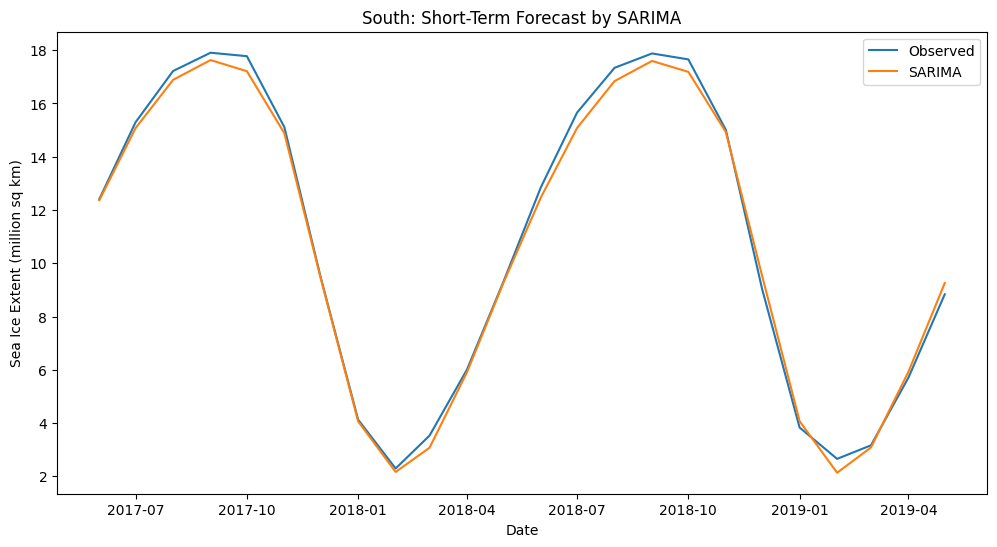

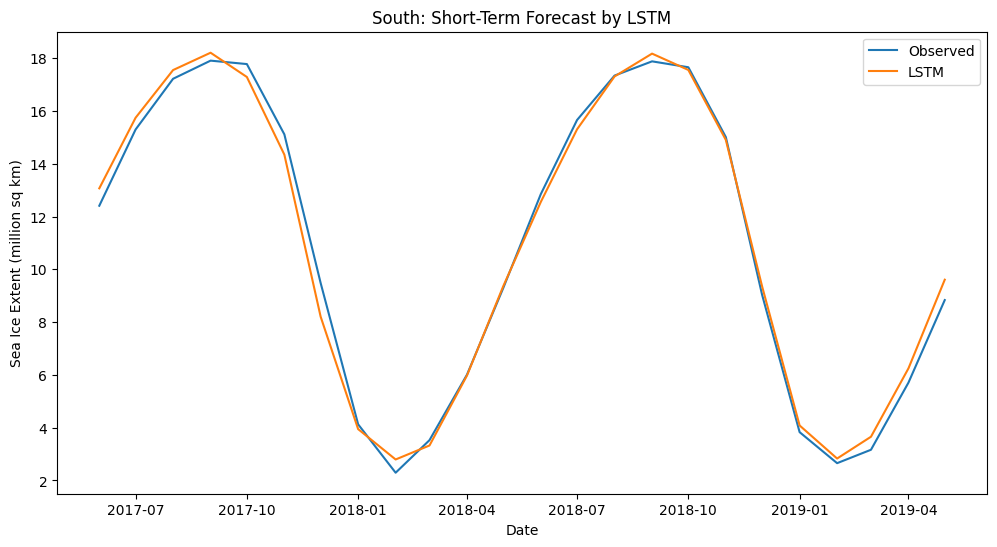

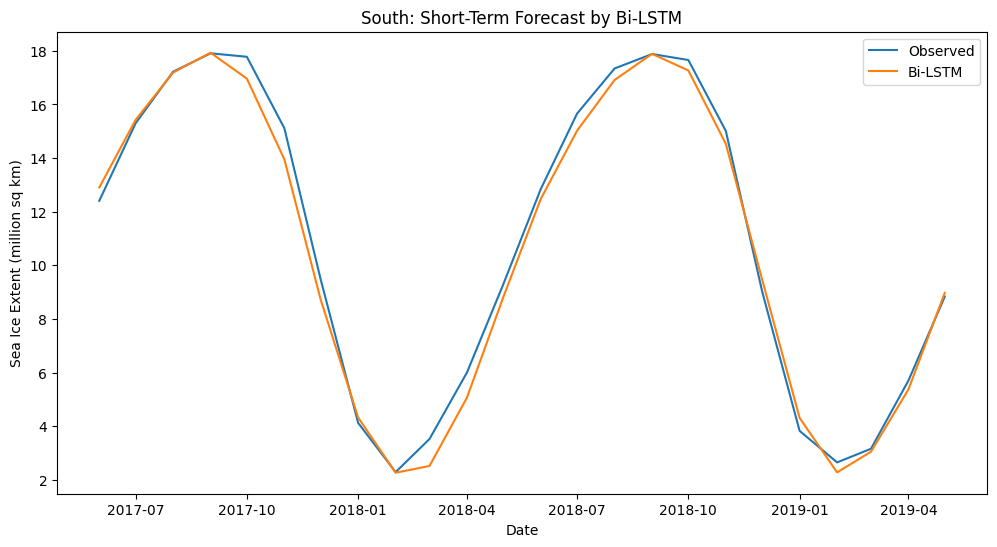

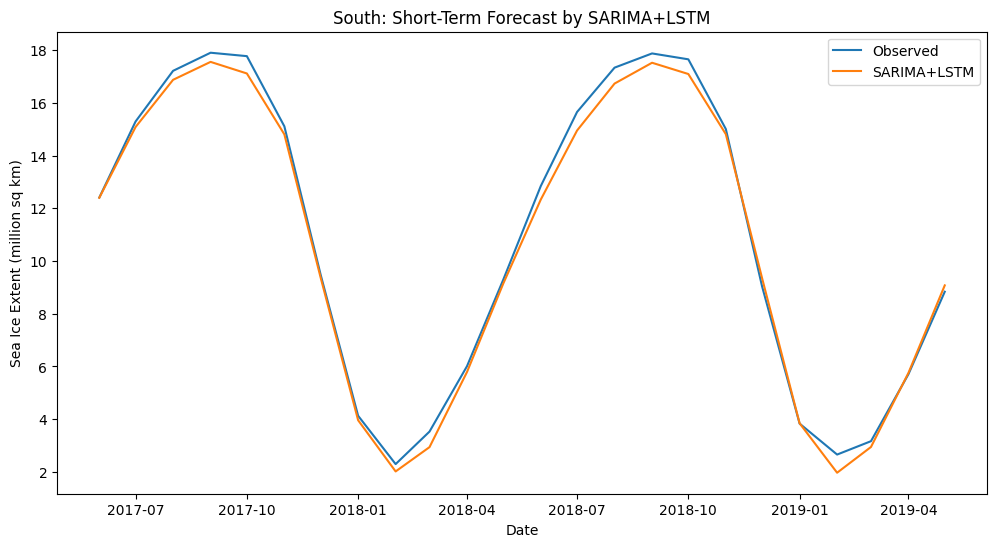

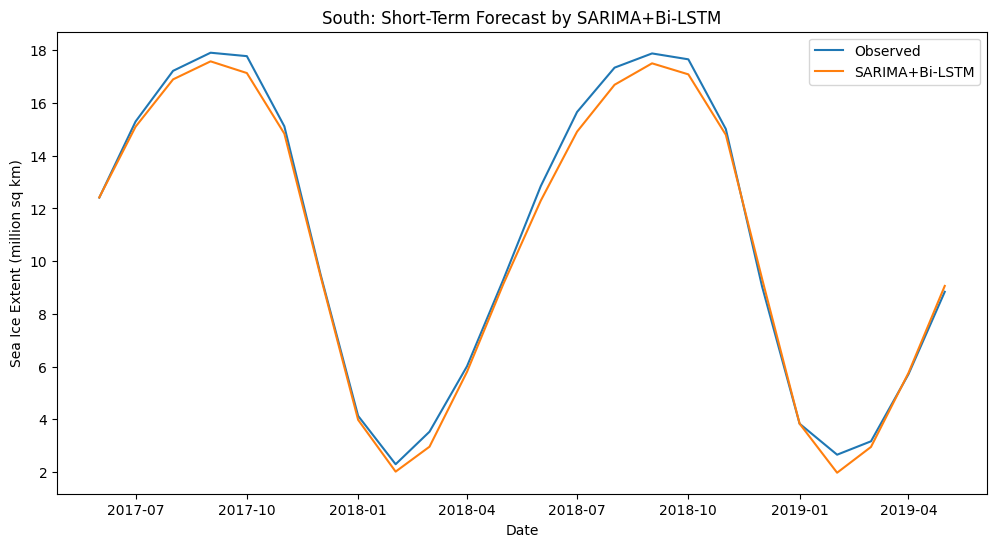

<Figure size 1200x600 with 0 Axes>

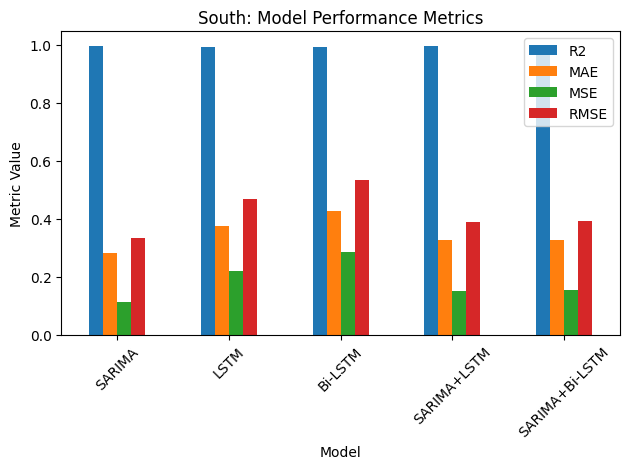

In [9]:
# Southern Hemisphere

# Filter and preprocess data
south_data = monthly_avg[monthly_avg['hemisphere'] == 'south'].copy()
south_data['Date'] = pd.to_datetime(south_data[['Year', 'Month']].assign(Day=1))
south_data = south_data.set_index('Date')[['Extent']]

# Split data
train_south = south_data.iloc[:-24]
test_south = south_data.iloc[-24:]

# SARIMA Model
sarima_model_south = SARIMAX(train_south['Extent'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit_south = sarima_model_south.fit(disp=False)
sarima_forecast_south = sarima_fit_south.forecast(steps=len(test_south))
metrics_dict['south']['SARIMA'] = calculate_metrics(test_south['Extent'], sarima_forecast_south)

# Long-term SARIMA forecast (to 2100)
future_dates_south = pd.date_range(start=south_data.index[-1] + pd.offsets.MonthBegin(1), end='2100-12-01', freq='MS')
sarima_long_forecast_south = sarima_fit_south.forecast(steps=len(future_dates_south))

# Prepare data for LSTM
scaler_south = MinMaxScaler()
scaled_data_south = scaler_south.fit_transform(south_data['Extent'].values.reshape(-1, 1))
# Clip scaled data to avoid extreme values
scaled_data_south = np.clip(scaled_data_south, -1e10, 1e10)
seq_length = 12
X_south, y_south = create_sequences(scaled_data_south, seq_length)
train_size_south = len(X_south) - 24
X_train_south, X_test_south = X_south[:train_size_south], X_south[train_size_south:]
y_train_south, y_test_south = y_south[:train_size_south], y_south[train_size_south:]

# LSTM Model
lstm_model_south = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=False),
    Dense(1)
])
lstm_model_south.compile(optimizer='adam', loss='mse')
lstm_model_south.fit(X_train_south, y_train_south, epochs=50, batch_size=32, verbose=0)
lstm_pred_south = lstm_model_south.predict(X_test_south, verbose=0)
lstm_pred_south = scaler_south.inverse_transform(lstm_pred_south)
y_test_true_south = scaler_south.inverse_transform(y_test_south)
metrics_dict['south']['LSTM'] = calculate_metrics(y_test_true_south.flatten(), lstm_pred_south.flatten())

# Long-term LSTM forecast with clipping
initial_sequence_south = np.clip(scaled_data_south[-seq_length:], -1e10, 1e10)
lstm_long_forecast_south = recursive_forecast(lstm_model_south, initial_sequence_south, len(future_dates_south), scaler_south)

# Bi-LSTM Model
bilstm_model_south = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(seq_length, 1)),
    Dense(1)
])
bilstm_model_south.compile(optimizer='adam', loss='mse')
bilstm_model_south.fit(X_train_south, y_train_south, epochs=50, batch_size=32, verbose=0)
bilstm_pred_south = bilstm_model_south.predict(X_test_south, verbose=0)
bilstm_pred_south = scaler_south.inverse_transform(bilstm_pred_south)
metrics_dict['south']['Bi-LSTM'] = calculate_metrics(y_test_true_south.flatten(), bilstm_pred_south.flatten())

# Long-term Bi-LSTM forecast with clipping
bilstm_long_forecast_south = recursive_forecast(bilstm_model_south, initial_sequence_south, len(future_dates_south), scaler_south)

# SARIMA+LSTM Model
# Compute residuals
sarima_train_pred_south = sarima_fit_south.predict(start=train_south.index[0], end=train_south.index[-1])
residuals_south = train_south['Extent'] - sarima_train_pred_south
scaler_residuals_south = MinMaxScaler()
scaled_residuals_south = scaler_residuals_south.fit_transform(residuals_south.values.reshape(-1, 1))
# Clip scaled residuals
scaled_residuals_south = np.clip(scaled_residuals_south, -1e10, 1e10)
X_res_south, y_res_south = create_sequences(scaled_residuals_south, seq_length)
train_size_res_south = len(X_res_south) - 24
X_train_res_south, X_test_res_south = X_res_south[:train_size_res_south], X_res_south[train_size_res_south:]
y_train_res_south, y_test_res_south = y_res_south[:train_size_res_south], y_res_south[train_size_res_south:]

# Train LSTM on residuals
lstm_residual_model_south = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=False),
    Dense(1)
])
lstm_residual_model_south.compile(optimizer='adam', loss='mse')
lstm_residual_model_south.fit(X_train_res_south, y_train_res_south, epochs=50, batch_size=32, verbose=0)
lstm_residual_pred_south = lstm_residual_model_south.predict(X_test_res_south, verbose=0)
lstm_residual_pred_south = scaler_residuals_south.inverse_transform(lstm_residual_pred_south)
sarima_lstm_pred_south = sarima_forecast_south + lstm_residual_pred_south.flatten()
metrics_dict['south']['SARIMA+LSTM'] = calculate_metrics(test_south['Extent'], sarima_lstm_pred_south)

# Long-term SARIMA+LSTM forecast
initial_residual_sequence_south = np.clip(scaled_residuals_south[-seq_length:], -1e10, 1e10)
lstm_residual_long_south = recursive_forecast(lstm_residual_model_south, initial_residual_sequence_south, len(future_dates_south), scaler_residuals_south)
sarima_lstm_long_south = sarima_long_forecast_south + lstm_residual_long_south.flatten()

# SARIMA+Bi-LSTM Model
bilstm_residual_model_south = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(seq_length, 1)),
    Dense(1)
])
bilstm_residual_model_south.compile(optimizer='adam', loss='mse')
bilstm_residual_model_south.fit(X_train_res_south, y_train_res_south, epochs=50, batch_size=32, verbose=0)
bilstm_residual_pred_south = bilstm_residual_model_south.predict(X_test_res_south, verbose=0)
bilstm_residual_pred_south = scaler_residuals_south.inverse_transform(bilstm_residual_pred_south)
sarima_bilstm_pred_south = sarima_forecast_south + bilstm_residual_pred_south.flatten()
metrics_dict['south']['SARIMA+Bi-LSTM'] = calculate_metrics(test_south['Extent'], sarima_bilstm_pred_south)

# Long-term SARIMA+Bi-LSTM forecast
bilstm_residual_long_south = recursive_forecast(bilstm_residual_model_south, initial_residual_sequence_south, len(future_dates_south), scaler_residuals_south)
sarima_bilstm_long_south = sarima_long_forecast_south + bilstm_residual_long_south.flatten()

# Save short-term forecasts
short_term_df_south = pd.DataFrame({
    'Date': test_south.index,
    'Actual': test_south['Extent'],
    'SARIMA': sarima_forecast_south,
    'LSTM': lstm_pred_south.flatten(),
    'Bi-LSTM': bilstm_pred_south.flatten(),
    'SARIMA+LSTM': sarima_lstm_pred_south,
    'SARIMA+Bi-LSTM': sarima_bilstm_pred_south
})
short_term_df_south.to_csv('short_term_forecasts_south.csv', index=False)

# Save long-term forecasts
long_term_df_south = pd.DataFrame({
    'Date': future_dates_south,
    'SARIMA': sarima_long_forecast_south,
    'LSTM': lstm_long_forecast_south.flatten(),
    'Bi-LSTM': bilstm_long_forecast_south.flatten(),
    'SARIMA+LSTM': sarima_lstm_long_south,
    'SARIMA+Bi-LSTM': sarima_bilstm_long_south
})
long_term_df_south.to_csv('long_term_forecasts_south.csv', index=False)

# Save metrics
metrics_df_south = pd.DataFrame(metrics_dict['south']).T
metrics_df_south.to_csv('metrics_south.csv')
print(metrics_dict)

# Visualizations
plt.figure(figsize=(12, 6))
plt.plot(test_south.index, test_south['Extent'], label='Observed')
plt.plot(test_south.index, sarima_forecast_south, label='SARIMA')
plt.title('South: Short-Term Forecast by SARIMA')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent (million sq km)')
plt.legend()
plt.savefig('short_term_forecast_south.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_south.index, test_south['Extent'], label='Observed')
plt.plot(test_south.index, lstm_pred_south, label='LSTM')
plt.title('South: Short-Term Forecast by LSTM')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent (million sq km)')
plt.legend()
plt.savefig('short_term_forecast_south.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_south.index, test_south['Extent'], label='Observed')
plt.plot(test_south.index, bilstm_pred_south, label='Bi-LSTM')
plt.title('South: Short-Term Forecast by Bi-LSTM')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent (million sq km)')
plt.legend()
plt.savefig('short_term_forecast_south.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_south.index, test_south['Extent'], label='Observed')
plt.plot(test_south.index, sarima_lstm_pred_south, label='SARIMA+LSTM')
plt.title('South: Short-Term Forecast by SARIMA+LSTM')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent (million sq km)')
plt.legend()
plt.savefig('short_term_forecast_south.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_south.index, test_south['Extent'], label='Observed')
plt.plot(test_south.index, sarima_bilstm_pred_south, label='SARIMA+Bi-LSTM')
plt.title('South: Short-Term Forecast by SARIMA+Bi-LSTM')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent (million sq km)')
plt.legend()
plt.savefig('short_term_forecast_south.png')
plt.show()

plt.figure(figsize=(12, 6))
metrics_df_south.plot(kind='bar')
plt.title('South: Model Performance Metrics')
plt.ylabel('Metric Value')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('metrics_south.png')
plt.show()

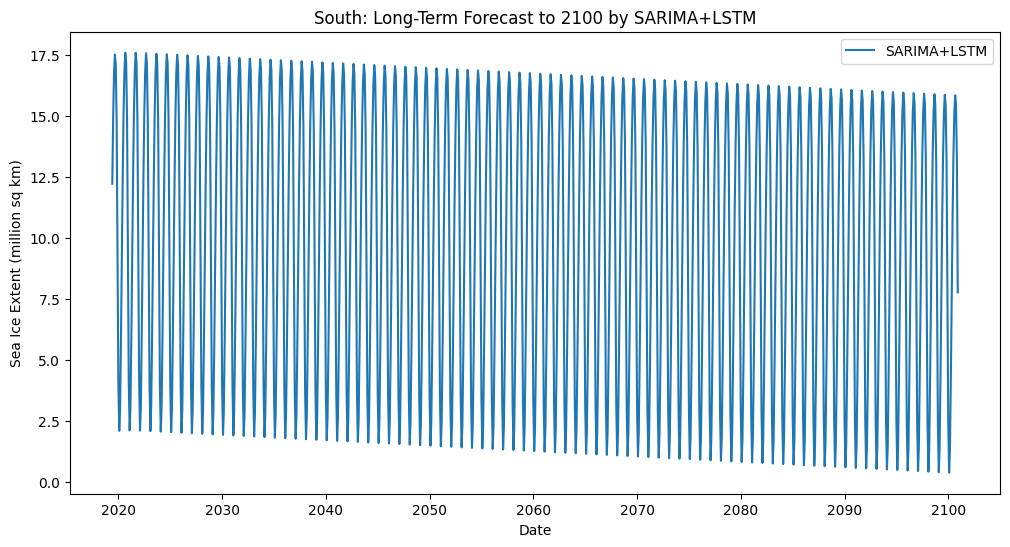

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(future_dates_south, sarima_lstm_long_south, label='SARIMA+LSTM')
plt.title('South: Long-Term Forecast to 2100 by SARIMA+LSTM')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent (million sq km)')
plt.legend()
plt.savefig('long_term_forecast_south.png')
plt.show()